In [2]:
import numpy as np
import nnfs
from nnfs.datasets import spiral_data
import seaborn as sns
import matplotlib.pyplot as plt

nnfs.init()


# Dense layer
class Layer_Dense:

    # Layer initialization
    def __init__(self, n_inputs, n_neurons):
        # Initialize weights and biases
        self.weights = 0.01 * np.random.randn(n_inputs, n_neurons)
        self.biases = np.zeros((1, n_neurons))

    # Forward pass
    def forward(self, inputs):
        # Remember input values
        self.inputs = inputs
        # Calculate output values from inputs, weights and biases
        self.output = np.dot(inputs, self.weights) + self.biases

    # Backward pass
    def backward(self, dvalues):
        # Gradients on parameters
        self.dweights = np.dot(self.inputs.T, dvalues)
        self.dbiases = np.sum(dvalues, axis=0, keepdims=True)
        # Gradient on values
        self.dinputs = np.dot(dvalues, self.weights.T)


# ReLU activation
class Activation_ReLU:

    # Forward pass
    def forward(self, inputs):

        # Remember input values
        self.inputs = inputs
        # Calculate output values from inputs
        self.output = np.maximum(0, inputs)

    # Backward pass
    def backward(self, dvalues):
        # Since we need to modify original variable,
        # let's make a copy of values first
        self.dinputs = dvalues.copy()

        # Zero gradient where input values were negative
        self.dinputs[self.inputs <= 0] = 0


# Softmax activation
class Activation_Softmax:

    # Forward pass
    def forward(self, inputs):
        # Remember input values
        self.inputs = inputs

        # Get unnormalized probabilities
        exp_values = np.exp(inputs - np.max(inputs, axis=1,
                                            keepdims=True))
        # Normalize them for each sample
        probabilities = exp_values / np.sum(exp_values, axis=1,
                                            keepdims=True)

        self.output = probabilities

    # Backward pass
    def backward(self, dvalues):

        # Create uninitialized array
        self.dinputs = np.empty_like(dvalues)

        # Enumerate outputs and gradients
        for index, (single_output, single_dvalues) in \
                enumerate(zip(self.output, dvalues)):
            # Flatten output array
            single_output = single_output.reshape(-1, 1)
            # Calculate Jacobian matrix of the output
            jacobian_matrix = np.diagflat(single_output) - \
                              np.dot(single_output, single_output.T)

            # Calculate sample-wise gradient
            # and add it to the array of sample gradients
            self.dinputs[index] = np.dot(jacobian_matrix,
                                         single_dvalues)


# Common loss class
class Loss:

    # Calculates the data and regularization losses
    # given model output and ground truth values
    def calculate(self, output, y):

        # Calculate sample losses
        sample_losses = self.forward(output, y)

        # Calculate mean loss
        data_loss = np.mean(sample_losses)

        # Return loss
        return data_loss


# Cross-entropy loss
class Loss_CategoricalCrossentropy(Loss):

    # Forward pass
    def forward(self, y_pred, y_true):

        # Number of samples in a batch
        samples = len(y_pred)

        # Clip data to prevent division by 0
        # Clip both sides to not drag mean towards any value
        y_pred_clipped = np.clip(y_pred, 1e-7, 1 - 1e-7)

        # Probabilities for target values -
        # only if categorical labels
        if len(y_true.shape) == 1:
            correct_confidences = y_pred_clipped[
                range(samples),
                y_true
            ]


        # Mask values - only for one-hot encoded labels
        elif len(y_true.shape) == 2:
            correct_confidences = np.sum(
                y_pred_clipped * y_true,
                axis=1
            )

        # Losses
        negative_log_likelihoods = -np.log(correct_confidences)
        return negative_log_likelihoods

    # Backward pass
    def backward(self, dvalues, y_true):

        # Number of samples
        samples = len(dvalues)
        # Number of labels in every sample
        # We'll use the first sample to count them
        labels = len(dvalues[0])

        # If labels are sparse, turn them into one-hot vector
        if len(y_true.shape) == 1:
            y_true = np.eye(labels)[y_true]

        # Calculate gradient
        self.dinputs = -y_true / dvalues
        # Normalize gradient
        self.dinputs = self.dinputs / samples


# Softmax classifier - combined Softmax activation
# and cross-entropy loss for faster backward step
class Activation_Softmax_Loss_CategoricalCrossentropy():

    # Creates activation and loss function objects
    def __init__(self):
        self.activation = Activation_Softmax()
        self.loss = Loss_CategoricalCrossentropy()

    # Forward pass
    def forward(self, inputs, y_true):
        # Output layer's activation function
        self.activation.forward(inputs)
        # Set the output
        self.output = self.activation.output
        # Calculate and return loss value
        return self.loss.calculate(self.output, y_true)


    # Backward pass
    def backward(self, dvalues, y_true):

        # Number of samples
        samples = len(dvalues)

        # If labels are one-hot encoded,
        # turn them into discrete values
        if len(y_true.shape) == 2:
            y_true = np.argmax(y_true, axis=1)

        # Copy so we can safely modify
        self.dinputs = dvalues.copy()
        # Calculate gradient
        self.dinputs[range(samples), y_true] -= 1
        # Normalize gradient
        self.dinputs = self.dinputs / samples
        
class Optimizer_SGD:
    # Initialize optimizer - set settings,
    # learning rate of 1. is default for this optimizer
    def __init__(self, learning_rate=1.0):
        self.learning_rate = learning_rate
        
    # Update parameters
    def update_params(self, layer):
        layer.weights += -self.learning_rate * layer.dweights
        layer.biases += -self.learning_rate * layer.dbiases

In [3]:
# Create dataset
X, y = spiral_data(samples=100, classes=3)

In [4]:
# Create Dense layer with 2 input features and 64 output values
dense1 = Layer_Dense(2, 64)

In [5]:
# Create ReLU activation (to be used with Dense layer):
activation1 = Activation_ReLU()

In [6]:
# Create second Dense layer with 64 input features (as we take output
# of previous layer here) and 3 output values (output values)
dense2 = Layer_Dense(64, 3)

In [7]:
# Create Softmax classifier's combined loss and activation
loss_activation = Activation_Softmax_Loss_CategoricalCrossentropy()

In [8]:
# Create optimizer
optimizer = Optimizer_SGD(learning_rate=.85)

In [22]:
loss_acum = []
accuracy_acum = []
count = []
y_hat = []

# Train in loop
for epoch in range(100001):
    # Perform a forward pass of our training data through this layer
    dense1.forward(X)
    
    # Perform a forward pass through activation function
    # takes the output of first dense layer here
    activation1.forward(dense1.output)
    
    # Perform a forward pass through second Dense layer
    # takes outputs of activation function of first layer as inputs
    dense2.forward(activation1.output)

    # Perform a forward pass through the activation/loss function
    # takes the output of second dense layer here and returns loss
    loss = loss_activation.forward(dense2.output, y)
    loss_acum.append(loss)
    
    # Calculate accuracy from output of activation2 and targets
    # calculate values along first axis
    predictions = np.argmax(loss_activation.output, axis=1)
    
    y_hat = predictions
    
    if len(y.shape) == 2:
        y = np.argmax(y, axis=1)
    accuracy = np.mean(predictions==y)
    accuracy_acum.append(accuracy)
    
    if not epoch % 100:
        print(f'epoch: {epoch}, ' +
              f'acc: {accuracy:.3f}, ' +
              f'loss: {loss:.3f}')
        
    # Backward pass
    loss_activation.backward(loss_activation.output, y)
    dense2.backward(loss_activation.dinputs)
    activation1.backward(dense2.dinputs)
    dense1.backward(activation1.dinputs)
    
    # Update weights and biases
    optimizer.update_params(dense1)
    optimizer.update_params(dense2)
    count.append(epoch)


epoch: 0, acc: 0.817, loss: 0.462
epoch: 100, acc: 0.810, loss: 0.561
epoch: 200, acc: 0.820, loss: 0.533
epoch: 300, acc: 0.810, loss: 0.455
epoch: 400, acc: 0.817, loss: 0.559
epoch: 500, acc: 0.613, loss: 1.891
epoch: 600, acc: 0.803, loss: 0.529
epoch: 700, acc: 0.813, loss: 0.483
epoch: 800, acc: 0.810, loss: 0.523
epoch: 900, acc: 0.823, loss: 0.461
epoch: 1000, acc: 0.800, loss: 0.589
epoch: 1100, acc: 0.810, loss: 0.530
epoch: 1200, acc: 0.843, loss: 0.462
epoch: 1300, acc: 0.800, loss: 0.527
epoch: 1400, acc: 0.630, loss: 1.547
epoch: 1500, acc: 0.817, loss: 0.537
epoch: 1600, acc: 0.810, loss: 0.564
epoch: 1700, acc: 0.827, loss: 0.535
epoch: 1800, acc: 0.800, loss: 0.597
epoch: 1900, acc: 0.800, loss: 0.535
epoch: 2000, acc: 0.817, loss: 0.544
epoch: 2100, acc: 0.800, loss: 0.520
epoch: 2200, acc: 0.810, loss: 0.528
epoch: 2300, acc: 0.803, loss: 0.529
epoch: 2400, acc: 0.807, loss: 0.495
epoch: 2500, acc: 0.807, loss: 0.543
epoch: 2600, acc: 0.817, loss: 0.542
epoch: 2700, 

epoch: 22000, acc: 0.810, loss: 0.445
epoch: 22100, acc: 0.817, loss: 0.486
epoch: 22200, acc: 0.793, loss: 0.555
epoch: 22300, acc: 0.820, loss: 0.454
epoch: 22400, acc: 0.820, loss: 0.469
epoch: 22500, acc: 0.820, loss: 0.498
epoch: 22600, acc: 0.820, loss: 0.450
epoch: 22700, acc: 0.810, loss: 0.453
epoch: 22800, acc: 0.803, loss: 0.452
epoch: 22900, acc: 0.817, loss: 0.441
epoch: 23000, acc: 0.840, loss: 0.478
epoch: 23100, acc: 0.810, loss: 0.605
epoch: 23200, acc: 0.833, loss: 0.537
epoch: 23300, acc: 0.853, loss: 0.462
epoch: 23400, acc: 0.817, loss: 0.576
epoch: 23500, acc: 0.860, loss: 0.443
epoch: 23600, acc: 0.850, loss: 0.485
epoch: 23700, acc: 0.850, loss: 0.462
epoch: 23800, acc: 0.837, loss: 0.505
epoch: 23900, acc: 0.853, loss: 0.448
epoch: 24000, acc: 0.860, loss: 0.407
epoch: 24100, acc: 0.813, loss: 0.446
epoch: 24200, acc: 0.800, loss: 0.512
epoch: 24300, acc: 0.777, loss: 0.507
epoch: 24400, acc: 0.807, loss: 0.509
epoch: 24500, acc: 0.830, loss: 0.524
epoch: 24600

epoch: 43500, acc: 0.857, loss: 0.387
epoch: 43600, acc: 0.810, loss: 0.480
epoch: 43700, acc: 0.823, loss: 0.440
epoch: 43800, acc: 0.857, loss: 0.476
epoch: 43900, acc: 0.850, loss: 0.450
epoch: 44000, acc: 0.807, loss: 0.674
epoch: 44100, acc: 0.860, loss: 0.440
epoch: 44200, acc: 0.753, loss: 0.958
epoch: 44300, acc: 0.827, loss: 0.423
epoch: 44400, acc: 0.833, loss: 0.399
epoch: 44500, acc: 0.803, loss: 0.522
epoch: 44600, acc: 0.823, loss: 0.408
epoch: 44700, acc: 0.697, loss: 0.825
epoch: 44800, acc: 0.820, loss: 0.458
epoch: 44900, acc: 0.813, loss: 0.489
epoch: 45000, acc: 0.840, loss: 0.439
epoch: 45100, acc: 0.803, loss: 0.526
epoch: 45200, acc: 0.827, loss: 0.420
epoch: 45300, acc: 0.817, loss: 0.509
epoch: 45400, acc: 0.743, loss: 0.929
epoch: 45500, acc: 0.857, loss: 0.449
epoch: 45600, acc: 0.800, loss: 0.685
epoch: 45700, acc: 0.827, loss: 0.437
epoch: 45800, acc: 0.703, loss: 0.874
epoch: 45900, acc: 0.823, loss: 0.450
epoch: 46000, acc: 0.827, loss: 0.411
epoch: 46100

epoch: 65200, acc: 0.827, loss: 0.425
epoch: 65300, acc: 0.817, loss: 0.449
epoch: 65400, acc: 0.843, loss: 0.422
epoch: 65500, acc: 0.797, loss: 0.512
epoch: 65600, acc: 0.580, loss: 3.227
epoch: 65700, acc: 0.840, loss: 0.504
epoch: 65800, acc: 0.853, loss: 0.395
epoch: 65900, acc: 0.843, loss: 0.494
epoch: 66000, acc: 0.843, loss: 0.463
epoch: 66100, acc: 0.830, loss: 0.461
epoch: 66200, acc: 0.843, loss: 0.423
epoch: 66300, acc: 0.860, loss: 0.408
epoch: 66400, acc: 0.800, loss: 0.474
epoch: 66500, acc: 0.827, loss: 0.417
epoch: 66600, acc: 0.800, loss: 0.568
epoch: 66700, acc: 0.813, loss: 0.455
epoch: 66800, acc: 0.833, loss: 0.409
epoch: 66900, acc: 0.860, loss: 0.425
epoch: 67000, acc: 0.827, loss: 0.435
epoch: 67100, acc: 0.823, loss: 0.449
epoch: 67200, acc: 0.837, loss: 0.522
epoch: 67300, acc: 0.847, loss: 0.498
epoch: 67400, acc: 0.820, loss: 0.457
epoch: 67500, acc: 0.817, loss: 0.508
epoch: 67600, acc: 0.863, loss: 0.414
epoch: 67700, acc: 0.817, loss: 0.448
epoch: 67800

epoch: 86700, acc: 0.823, loss: 0.438
epoch: 86800, acc: 0.830, loss: 0.403
epoch: 86900, acc: 0.850, loss: 0.495
epoch: 87000, acc: 0.853, loss: 0.470
epoch: 87100, acc: 0.787, loss: 0.766
epoch: 87200, acc: 0.823, loss: 0.565
epoch: 87300, acc: 0.690, loss: 1.515
epoch: 87400, acc: 0.817, loss: 0.460
epoch: 87500, acc: 0.860, loss: 0.394
epoch: 87600, acc: 0.813, loss: 0.465
epoch: 87700, acc: 0.820, loss: 0.495
epoch: 87800, acc: 0.763, loss: 0.631
epoch: 87900, acc: 0.820, loss: 0.456
epoch: 88000, acc: 0.817, loss: 0.456
epoch: 88100, acc: 0.767, loss: 0.598
epoch: 88200, acc: 0.853, loss: 0.410
epoch: 88300, acc: 0.823, loss: 0.580
epoch: 88400, acc: 0.803, loss: 0.657
epoch: 88500, acc: 0.833, loss: 0.418
epoch: 88600, acc: 0.817, loss: 0.484
epoch: 88700, acc: 0.820, loss: 0.495
epoch: 88800, acc: 0.810, loss: 0.523
epoch: 88900, acc: 0.810, loss: 0.459
epoch: 89000, acc: 0.830, loss: 0.402
epoch: 89100, acc: 0.857, loss: 0.467
epoch: 89200, acc: 0.740, loss: 0.997
epoch: 89300

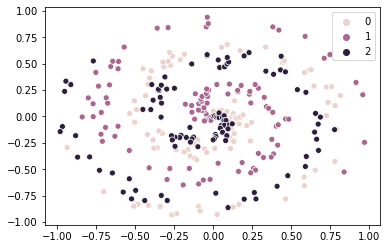

In [27]:
sns.scatterplot(x=X[:, 0], y=X[:, 1], hue=y)

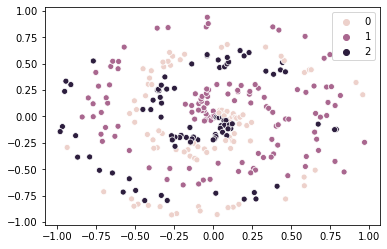

In [28]:
sns.scatterplot(x=X[:, 0], y=X[:, 1], hue=y_hat)

(0.0, 5.0)

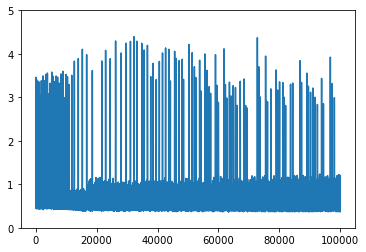

In [29]:
sns.lineplot(y=loss_acum, x=count)
plt.ylim(0, 5)

(0.3, 0.8)

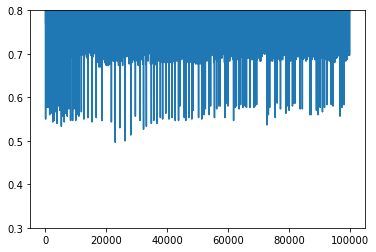

In [30]:
sns.lineplot(y=accuracy_acum , x=count)
plt.ylim(0.3, 0.8)